In [1]:
from __future__ import print_function
import os
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import string
import warnings

from sklearn import svm, datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

from sklearn import preprocessing

import datetime as dt

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# for showing all the plots inline
%matplotlib inline


In [2]:
all_ticket_df=pd.read_csv('all_tickets_processed_3topics.csv')


In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
        
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Model Loss')
    plt.legend()

In [4]:
all_ticket_df.head()


,title,body,Target
0,NaN,hi since recruiter lead permission approve req...,1
1,connection with icon,icon dear please setup icon per icon engineers...,2
2,work experience user,work experience user hi work experience studen...,0
3,requesting for meeting,requesting meeting hi please help follow equip...,1
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,2


In [5]:
all_ticket_df['Target'].value_counts()


2    23526
0    17734
1     7289
Name: Target, dtype: int64

# Balancing the DataSet

In [7]:
all_ticket_df_label0=all_ticket_df[all_ticket_df['Target']==0][:7289]
all_ticket_df_label1=all_ticket_df[all_ticket_df['Target']==1]
all_ticket_df_label2=all_ticket_df[all_ticket_df['Target']==2][:7289]

balanced_df=all_ticket_df_label0.append([all_ticket_df_label1,all_ticket_df_label2])

# shuffle the DataFrame rows 
balanced_df = balanced_df.sample(frac = 1)

In [8]:
balanced_df['Target'].value_counts()

2    7289
1    7289
0    7289
Name: Target, dtype: int64

# Extracting features from text

In [9]:
def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    #logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data.values)
        test_feature_set=cv.transform(testing_data.values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data.values)
        
        train_feature_set=cv.transform(training_data.values)
        test_feature_set=cv.transform(testing_data.values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer

# Splitting the data set in to training and testing sets

In [10]:
# GET A TRAIN TEST SPLIT (set seed for consistent results)
training_data, testing_data = train_test_split(balanced_df,random_state = 2000)

# GET LABELS
Y_train=training_data['Target'].values
Y_test=testing_data['Target'].values

# GET FEATURES
X_train,X_test,feature_transformer=extract_features(balanced_df,'body',training_data,testing_data,type='feature_rep')

# Using Grid Search CV to get the best parameters

In [ ]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid_search = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

grid_search.fit(X_train, Y_train)
grid_search.best_params_
  

In [15]:
# Fitting the model
rbf = svm.SVC(kernel='rbf', gamma=0.1, C=100).fit(X_train, Y_train)

In [16]:
# Predicting using test data
rbf_pred = rbf.predict(X_test)

In [18]:
rbf_accuracy = accuracy_score(Y_test, rbf_pred)
rbf_f1 = f1_score(Y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

Accuracy (RBF Kernel):  92.08
F1 (RBF Kernel):  92.08


# Plotting Confusion Matrix For Polynomial Kernel

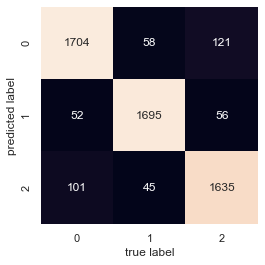

In [19]:
# Ploting confusion matrix with 'seaborn' module
# Use below line only with Jupyter Notebook
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
mat = confusion_matrix(Y_test, rbf_pred)
plt.figure(figsize=(4, 4))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(Y_test),
            yticklabels=np.unique(Y_test))
plt.xlabel('true label')
plt.ylabel('predicted label')
# Save confusion matrix to outputs in Workbench
# plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
plt.show()